
# **TMS 2025 AI Workshop: Ryan Jacobs, Ben Afflerbach, Dane Morgan (UW-Madison)**

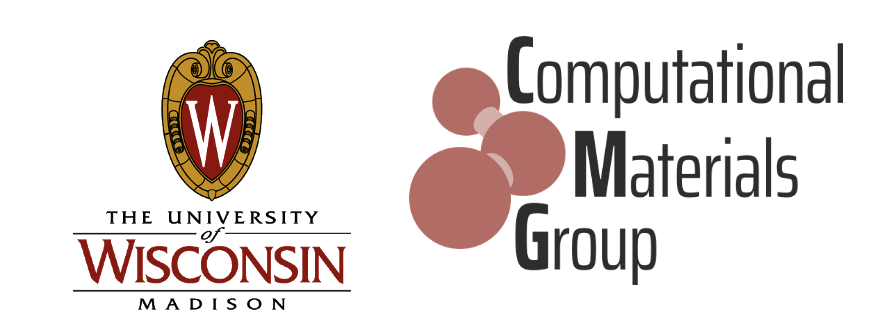

---


## Google Colab notebook for finetuning Mattergen: example of
## conditional generation of high voltage Na-battery materials

# Part 1: Installation and setup

To begin, we need to install needed python dependencies to run Mattergen

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# These installs take about 1 minute

!uv pip install torch==2.4.1 torchvision==0.19.1
!uv pip install pymatgen mp_api emmet-core py3Dmol hydra-core pytorch-lightning==2.0.6 fire ase numpy==1.26.4

Using Python 3.12.12 environment at: /usr
Resolved 26 packages in 355ms
Prepared 14 packages in 1m 07s
Uninstalled 14 packages in 908ms
Installed 14 packages in 301ms
 - nvidia-cublas-cu12==12.6.4.1
 + nvidia-cublas-cu12==12.1.3.1
 - nvidia-cuda-cupti-cu12==12.6.80
 + nvidia-cuda-cupti-cu12==12.1.105
 - nvidia-cuda-nvrtc-cu12==12.6.77
 + nvidia-cuda-nvrtc-cu12==12.1.105
 - nvidia-cuda-runtime-cu12==12.6.77
 + nvidia-cuda-runtime-cu12==12.1.105
 - nvidia-cudnn-cu12==9.10.2.21
 + nvidia-cudnn-cu12==9.1.0.70
 - nvidia-cufft-cu12==11.3.0.4
 + nvidia-cufft-cu12==11.0.2.54
 - nvidia-curand-cu12==10.3.7.77
 + nvidia-curand-cu12==10.3.2.106
 - nvidia-cusolver-cu12==11.7.1.2
 + nvidia-cusolver-cu12==11.4.5.107
 - nvidia-cusparse-cu12==12.5.4.2
 + nvidia-cusparse-cu12==12.1.0.106
 - nvidia-nccl-cu12==2.27.3
 + nvidia-nccl-cu12==2.20.5
 - nvidia-nvtx-cu12==12.6.77
 + nvidia-nvtx-cu12==12.1.105
 - torch==2.8.0+cu126
 + torch==2.4.1
 - torchvision==0.23.0+cu126
 + torchvision==0.19.1
 - triton==3.4

Next, we specifically deal with the torch dependencies as they can be tricky

In [3]:
# These installs take about 45 seconds

import torch
print(torch.__version__)

!pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
!pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

2.4.1+cu121
Looking in links: https://data.pyg.org/whl/torch-2.4.1+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 46.3 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.4.1+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 41.5 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.4.1+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 34.2 MB/s eta 0:00:00
  Cloning https://github.com/pyg-team/pytorch_geometric.git to /tmp/pip-req-build-rw_8ac2n
  Running command git clone --filter=blob:none --quiet https://github.com/pyg-team/pytorch_geometric.git /tmp/pip-req-build-rw_8ac2n
  Resolved https://github.com/pyg-team/pytorch_geometric.git to commit 6208605b4d9711b86c7f06031b17efc5ea445afb
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch-geometric: filename=torch_geometric-2.8.0-py3-none-any

There is no PyPi release of Mattergen, so we clone it from Github.
We need to run the install so the shortcuts to the scripts work

In [4]:
!git clone https://github.com/microsoft/mattergen

import os
os.chdir('/content/mattergen')
#!pip install -e .
!pip install -e . --no-deps #Issues with installing deps, but this is needed to get script shortcuts working

Cloning into 'mattergen'...
remote: Enumerating objects: 1663, done.
remote: Counting objects: 100% (410/410), done.
remote: Compressing objects: 100% (163/163), done.
remote: Total 1663 (delta 305), reused 248 (delta 247), pack-reused 1253 (from 2)
Receiving objects: 100% (1663/1663), 3.38 MiB | 7.56 MiB/s, done.
Resolving deltas: 100% (659/659), done.
Obtaining file:///content/mattergen
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for mattergen (pyproject.toml) ... done
  Created wheel for mattergen: filename=mattergen-1.0.3-0.editable-py3-none-any.whl size=75505 sha256=705b9ff68e092b9fefe5513da0aab0bff2445c4d7b373e80b4cdc169a4cc8854
  Stored in directory: /tmp/pip-ephem-wheel-cache-u71xmjul/wheels/70/14/e2/3c7000c361845cb5a1e2a263829b656dff268c57d16f9718d1
Successfully built mattergen


Finally, we need to clone the mattergen_finetune repository so we have access to some of the data files needed in this notebook

In [6]:
!git clone https://github.com/uw-cmg/mattergen_finetune
!mv mattergen_finetune ../

fatal: destination path 'mattergen_finetune' already exists and is not an empty directory.


Now that everything is installed, we need to restart the runtime prior to importing packages so the new install can take effect

In [ ]:
# HERE- Need to do Runtime -> Restart Session in order for new installs to take effect

In [1]:
import joblib
import pandas as pd
import numpy as np
import os
from pymatgen.core import Structure, Composition
import py3Dmol
import matplotlib.pyplot as plt

import sys
sys.path.append('mattergen')
sys.path.append('/content/mattergen')

# Part 2: Obtaining the data used for Mattergen finetuning

There is a saved data file which contains the calculated
average voltage of Na insertion. The data were obtained by screening materials
from the Materials Project and calculting the voltage using a Universal
Machine Learning Interatomic Potential (U-MLIP)

In [2]:
import joblib, os
d = '/content/mattergen_finetune'

df = joblib.load(os.path.join(d, 'mp_Na_eqV2.pkl'))

df.head()

,index,"Relaxed structure, full","Relaxed structure, empty","Relaxed structure, ref","Relaxed energy, full","Relaxed energy, empty","Relaxed energy, ref","Relaxed volume, full","Relaxed volume, empty",Average voltage (V/ion),mp_id,Composition,Structure
0,0,"{'@module': 'pymatgen.core.structure', '@class...","{'@module': 'pymatgen.core.structure', '@class...","{'@module': 'pymatgen.core.structure', '@class...",-47.144470,-42.739342,-2.612235,86.925992,82.302897,3.099011,mp-1002571-GGA+U,NaMn2O4,"[[ 1.4537295 -0.858677 2.8019015] Na, [0. 0...."
1,0,"{'@module': 'pymatgen.core.structure', '@class...","{'@module': 'pymatgen.core.structure', '@class...","{'@module': 'pymatgen.core.structure', '@class...",-347.147003,-342.174774,-2.612235,580.632428,580.309435,3.666111,mp-1003635-GGA+U,NaMn16O32,"[[4.97042764 4.96925164 4.40963713] Na, [6.467..."
2,0,"{'@module': 'pymatgen.core.structure', '@class...","{'@module': 'pymatgen.core.structure', '@class...","{'@module': 'pymatgen.core.structure', '@class...",-360.532379,-342.138519,-2.612235,592.342169,578.011476,3.292347,mp-1003636-GGA+U,NaMn4O8,"[[3.75601408 7.43825464 1.65457529] Na, [ 5.16..."
3,0,"{'@module': 'pymatgen.core.structure', '@class...","{'@module': 'pymatgen.core.structure', '@class...","{'@module': 'pymatgen.core.structure', '@class...",-351.932495,-342.103943,-2.612235,585.379022,583.089731,3.608158,mp-1003638-GGA+U,NaMn8O16,"[[-4.9288659 5.00872719 -1.47329048] Na, [-9..."
4,0,"{'@module': 'pymatgen.core.structure', '@class...","{'@module': 'pymatgen.core.structure', '@class...","{'@module': 'pymatgen.core.structure', '@class...",-93.682617,-84.215996,-2.612235,162.257705,136.842690,3.427193,mp-1003766-GGA+U,NaMn2O4,"[[1.46205272 2.17082951 8.89991039] Na, [1.462..."


The data file contains U-MLIP relaxed structures and average voltages for 2288 materials. Let's plot a histogram of the computed average voltages to see their distribution:

In [3]:
def plot_voltage_histogram(df, dataset='MP', ion='Na'):
    bins = np.arange(0, 10, 0.2)

    # Matterverse avg voltage has a bunch of negative values- remove them!
    df = df[df['Average voltage (V/ion)'] >=0]

    plt.clf()

    plt.hist(bins=bins, x=df['Average voltage (V/ion)'], color='red', edgecolor='black', alpha=0.5, label='EquiformerV2')

    plt.xlabel('Average voltage (V/Na)', fontsize=14)
    plt.xticks(fontsize=12)
    plt.ylabel('Number of occurrences', fontsize=14)
    plt.yticks(fontsize=12)
    plt.legend(loc='best')
    plt.savefig('Voltage_histogram_'+dataset+'_'+ion+'.png', dpi=300, bbox_inches='tight')

    vals = df['Average voltage (V/ion)']
    print('EquiformerV2 stats')
    print(np.mean(vals), np.std(vals), min(vals), max(vals))

    return

EquiformerV2 stats
4.1346677545044805 0.9164283551284464 0.5237773656845093 6.9161494970321655


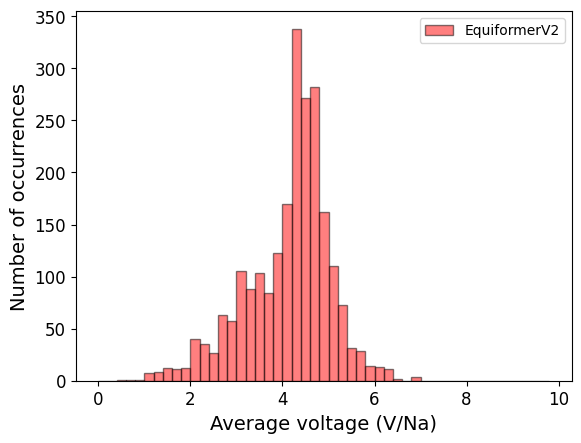

In [4]:
plot_voltage_histogram(df)

As we can see, the average voltage is around 4.1 V/Na, with numerous instances of high voltage materials.

Next, we can use a function to make a 3D visualization of a structure, which will also come in handy later for visualizing some generated structures from Mattergen

In [5]:
def show_structure_3d(struct, supercell=(1,1,1), style="ballstick", width=700, height=500, spin=False, labels=False):
    s = struct.copy()
    if supercell != (1,1,1):
        s.make_supercell(supercell)
    cif_str = s.to(fmt="cif")

    view = py3Dmol.view(width=width, height=height)
    view.addModel(cif_str, "cif")
    view.addUnitCell()
    view.setBackgroundColor("white")

    if style == "ballstick":
        view.setStyle({"sphere": {"scale": 0.23}, "stick": {"radius": 0.15}})
    elif style == "licorice":
        view.setStyle({"stick": {}})
    elif style == "vdw":
        view.setStyle({"sphere": {"scale": 0.3}})
    else:
        view.setStyle({"stick": {}})

    if labels:
        for site in s.sites:
            x, y, z = map(float, site.coords)  # cartesian Å
            view.addLabel(
                site.specie.symbol,
                {"position": {"x": x, "y": y, "z": z},
                  "fontSize": 12, "fontColor": "black",
                 "alignment": "center", "offset": {"x": 0, "y": 0},
                  "backgroundOpacity": 0.0}  # no background box
            )

    view.zoomTo()
    if spin:
        view.spin(True)
    return view.show()


In [6]:
# Visualize (change supercell/style as needed)
struct = df['Structure'].iloc[0]
print(struct.reduced_formula)
show_structure_3d(struct, supercell=(2, 2, 2), style="ballstick", labels=True)

NaMn2O4


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

# Part 3: Creating the input data for finetuning Mattergen

At this point we have a choice- we can go through all of the steps to make the data from scratch (Choice 1), or we can simply copy the result of that data creation from the mattergen_finetune directory and move on with the finetuning (Choice 2). Choice 1 is good for knowing how to make your own datasets for future runs, whereas Choice 2 is best for practical efficiency

# Part 3: (Choice 1): Make the data for Mattergen from scratch

In [7]:
os.chdir('/content/mattergen')
!git lfs pull -I data-release/mp-20/mp_20.zip --exclude=""
!unzip data-release/mp-20/mp_20.zip -d datasets


Archive:  data-release/mp-20/mp_20.zip
   creating: datasets/mp_20/
  inflating: datasets/mp_20/val.csv  
  inflating: datasets/mp_20/test.csv  
  inflating: datasets/mp_20/train.csv  


In [8]:
os.chdir('/content')

mp_id = df['mp_id']
voltage = df['Average voltage (V/ion)']

# MP-20 data
df_mp20_train = pd.read_csv('mattergen/datasets/mp_20/train.csv')
df_mp20_val = pd.read_csv('mattergen/datasets/mp_20/val.csv')
df_mp20_test = pd.read_csv('mattergen/datasets/mp_20/test.csv')

# Alex-MP data
#df_mp20_train = pd.read_csv('mattergen/datasets/alex_mp_20/train.csv')
#df_mp20_val = pd.read_csv('mattergen/datasets/mp_20/val.csv')
#df_mp20_test = pd.read_csv('mattergen/datasets/alex_mp_20/test.csv')

train_ids = df_mp20_train['material_id']
train_voltages = list()
num_found_train = 0

val_ids = df_mp20_val['material_id']
val_voltages = list()
num_found_val = 0

test_ids = df_mp20_test['material_id']
test_voltages = list()
num_found_test = 0

found_ids = list()

# Training data
for i in train_ids:
    found = False
    for j in mp_id:
        j_trim = j.split('-')[0]+'-'+j.split('-')[1]
        if i == j_trim:
            j_found = j
            #print('Found', i, j)
            #print(df_eqv2[df_eqv2['mp_id']==j])
            voltage = df[df['mp_id']==j]['Average voltage (V/ion)'].iloc[0]
            #print(voltage)
            train_voltages.append(voltage)
            found = True
            num_found_train += 1
            found_ids.append(j_found)
            continue
    if found == False:
        train_voltages.append(np.nan)
    #if found == True:
    #    found_ids.append(j_found)

print(mp_id.shape[0], num_found_train)

# Val data
for i in val_ids:
    found = False
    for j in mp_id:
        j_trim = j.split('-')[0]+'-'+j.split('-')[1]
        if i == j_trim:
            #print('Found', i, j)
            j_found = j
            #print(df_eqv2[df_eqv2['mp_id']==j])
            voltage = df[df['mp_id']==j]['Average voltage (V/ion)'].iloc[0]
            #print(voltage)
            val_voltages.append(voltage)
            found = True
            num_found_val += 1
            found_ids.append(j_found)
            continue
    if found == False:
        val_voltages.append(np.nan)
    #if found == True:
    #    found_ids.append(j_found)

print(mp_id.shape[0], num_found_val)

#'''
# Test data
for i in test_ids:
    found = False
    for j in mp_id:
        j_trim = j.split('-')[0]+'-'+j.split('-')[1]
        if i == j_trim:
            #print('Found', i, j)
            j_found = j
            #print(df_eqv2[df_eqv2['mp_id']==j])
            voltage = df[df['mp_id']==j]['Average voltage (V/ion)'].iloc[0]
            #print(voltage)
            test_voltages.append(voltage)
            found = True
            num_found_test += 1
            found_ids.append(j_found)
            continue
    if found == False:
        test_voltages.append(np.nan)
    #if found == True:
    #    found_ids.append(j_found)
#'''
print(mp_id.shape[0], num_found_test)

2288 215
2288 62
2288 73


In [9]:
from ast import literal_eval

chemsys = list()
for i in df_mp20_train['elements']:
    cs = ''
    for j in literal_eval(i):
        cs += j
        cs += '-'
    cs = cs[:-1]
    chemsys.append(cs)

df_mp20_train['chemical_system'] = chemsys

#'''
chemsys = list()
for i in df_mp20_test['elements']:
    cs = ''
    for j in literal_eval(i):
        cs += j
        cs += '-'
    cs = cs[:-1]
    chemsys.append(cs)

df_mp20_test['chemical_system'] = chemsys
#'''

chemsys = list()
for i in df_mp20_val['elements']:
    cs = ''
    for j in literal_eval(i):
        cs += j
        cs += '-'
    cs = cs[:-1]
    chemsys.append(cs)

df_mp20_val['chemical_system'] = chemsys

In [10]:
df_mp20_train['voltage'] = train_voltages
df_mp20_val['voltage'] = val_voltages
df_mp20_test['voltage'] = test_voltages

df_mp20_train

,Unnamed: 0,material_id,formation_energy_per_atom,dft_band_gap,pretty_formula,e_above_hull,elements,cif,spacegroup_number,azure_bulk_modulus,larsen_score_2d,Si_100_mismatch,azure_band_gap,dft_bulk_modulus,dft_poisson_ratio,dft_mag_density,chemical_system,voltage
0,0,mp-1221227,-1.637460,0.2133,Na3MnCoNiO6,0.043001,"['Co', 'Mn', 'Na', 'Ni', 'O']",# generated using pymatgen\r\ndata_Na3MnCoNiO6...,8.0,100.027488,0.000000e+00,0.014483,0.576968,NaN,NaN,7.068804e-02,Co-Mn-Na-Ni-O,3.05562
1,1,mp-974729,-0.314759,0.0000,Nd(Al2Cu)4,0.000000,"['Al', 'Cu', 'Nd']",# generated using pymatgen\r\ndata_Nd(Al2Cu)4\...,139.0,94.080115,0.000000e+00,0.023284,0.000028,NaN,NaN,2.025358e-09,Al-Cu-Nd,NaN
2,2,mp-1185360,-0.193761,0.0000,LiMnIr2,0.018075,"['Ir', 'Li', 'Mn']",# generated using pymatgen\r\ndata_LiMnIr2\r\n...,225.0,206.381562,0.000000e+00,0.001716,0.000003,NaN,NaN,4.048347e-02,Ir-Li-Mn,NaN
3,3,mp-1188861,-0.584694,3.8556,LiCSN,0.048847,"['C', 'Li', 'N', 'S']",# generated using pymatgen\r\ndata_LiCSN\r\n_s...,62.0,24.972078,1.221245e-15,0.002367,3.701200,NaN,NaN,1.194041e-06,C-Li-N-S,NaN
4,4,mp-677272,-2.474759,0.4707,La2EuS4,0.000000,"['Eu', 'La', 'S']",# generated using pymatgen\r\ndata_La2EuS4\r\n...,122.0,65.992807,0.000000e+00,0.011328,0.480415,NaN,NaN,6.011521e-03,Eu-La-S,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27131,27131,mp-568116,-0.988502,3.7614,Lu2(CN2)3,0.045185,"['C', 'Lu', 'N']",# generated using pymatgen\r\ndata_Lu2(CN2)3\r...,155.0,77.280985,0.000000e+00,0.006324,3.564688,NaN,NaN,1.181668e-07,C-Lu-N,NaN
27132,27132,mp-865529,-0.640955,0.0000,Ti2NiIr,0.000000,"['Ti', 'Ni', 'Ir']",# generated using pymatgen\r\ndata_Ti2NiIr\r\n...,225.0,190.245899,0.000000e+00,0.004418,0.000054,NaN,NaN,5.087075e-07,Ti-Ni-Ir,NaN
27133,27133,mp-1189241,-0.756019,0.0000,GdAs2Au,0.010305,"['As', 'Au', 'Gd']",# generated using pymatgen\r\ndata_GdAs2Au\r\n...,64.0,80.393989,0.000000e+00,0.002290,0.000083,NaN,NaN,8.247816e-02,As-Au-Gd,NaN
27134,27134,mp-1104538,-0.104870,0.0000,Tm(FeSn)6,0.021206,"['Fe', 'Sn', 'Tm']",# generated using pymatgen\r\ndata_Tm(FeSn)6\r...,191.0,93.928762,0.000000e+00,0.005980,0.000005,NaN,NaN,5.594809e-02,Fe-Sn-Tm,NaN


In [11]:
# Isolate the remaining entries that weren't already matched up
#df_eqv2

ids_left = list()
for i in df['mp_id']:
    if i not in found_ids:
        ids_left.append(i)

#df_eqv2_left = df_eqv2[df_eqv2['mp_id'] != found_ids]

In [12]:
# Split the leftover ids into train/val/test
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(ids_left, test_size=0.1, random_state=42)
X_test, X_val = train_test_split(X_test, test_size=0.5, random_state=42)

In [13]:
print(len(X_train), len(X_test))


1744 97


In [14]:
from pymatgen.io.cif import CifWriter

# Get the voltages, chemsys and structures for the remaining data
v_train = list()
s_train = list()
chem_train = list()
for i in X_train:
    df_sub = df[df['mp_id']==i]
    v_train.append(df_sub['Average voltage (V/ion)'].iloc[0])
    s = df_sub['Structure'].iloc[0]
    #print(s)
    cif_writer = CifWriter(s)
    cif_string = str(cif_writer)
    #print(cif_string)
    s_train.append(cif_string)
    elements = [str(s) for s in Composition(s.formula).elements]
    cs = ''
    for i in elements:
        cs += i
        cs += '-'
    cs = cs[:-1]
    chem_train.append(cs)

v_val = list()
s_val = list()
chem_val = list()
for i in X_val:
    df_sub = df[df['mp_id']==i]
    v_val.append(df_sub['Average voltage (V/ion)'].iloc[0])
    s = df_sub['Structure'].iloc[0]
    #print(s)
    cif_writer = CifWriter(s)
    cif_string = str(cif_writer)
    #print(cif_string)
    s_val.append(cif_string)
    elements = [str(s) for s in Composition(s.formula).elements]
    cs = ''
    for i in elements:
        cs += i
        cs += '-'
    cs = cs[:-1]
    chem_val.append(cs)

#'''
v_test = list()
s_test = list()
chem_test = list()
for i in X_test:
    df_sub = df[df['mp_id']==i]
    v_test.append(df_sub['Average voltage (V/ion)'].iloc[0])
    s = df_sub['Structure'].iloc[0]
    #print(s)
    cif_writer = CifWriter(s)
    cif_string = str(cif_writer)
    #print(cif_string)
    s_test.append(cif_string)
    elements = [str(s) for s in Composition(s.formula).elements]
    cs = ''
    for i in elements:
        cs += i
        cs += '-'
    cs = cs[:-1]
    chem_test.append(cs)
#'''

df_train_exp = pd.DataFrame({'voltage': v_train, 'chemical_system': chem_train, 'cif': s_train})
df_val_exp = pd.DataFrame({'voltage': v_val, 'chemical_system': chem_val, 'cif': s_val})
df_test_exp = pd.DataFrame({'voltage': v_test, 'chemical_system': chem_test, 'cif': s_test})


df_train_exp

,voltage,chemical_system,cif
0,6.144997,Ba-Na-Fe-F,# generated using pymatgen\ndata_BaNaFe2F9\n_s...
1,4.272989,Na-Zr-Nb-Si-O,# generated using pymatgen\ndata_Na3ZrNb(SiO4)...
2,3.471981,Na-Mn-As-O,# generated using pymatgen\ndata_NaMnAsO4\n_sy...
3,5.232151,Na-Eu-Ti-P-O,# generated using pymatgen\ndata_NaEuTi8(PO4)1...
4,4.291333,Na-Ti-Al-Si-P-O,# generated using pymatgen\ndata_Na3TiAlSi(PO6...
...,...,...,...
1739,4.934279,Na-Mg-Ti-P-S-O,# generated using pymatgen\ndata_NaMgTi3P3(SO8...
1740,3.433304,Na-Fe-O,# generated using pymatgen\ndata_Na3FeO3\n_sym...
1741,4.347549,Na-Ca-Ti-P-S-O,# generated using pymatgen\ndata_NaCa2Ti2PS5O2...
1742,4.129717,Ba-Na-Ti-Bi-O,# generated using pymatgen\ndata_Ba2Na7Ti16Bi7...


In [15]:
df_mp20_train_exp = pd.concat([df_mp20_train, df_train_exp])
df_mp20_val_exp = pd.concat([df_mp20_val, df_val_exp])
df_mp20_test_exp = pd.concat([df_mp20_test, df_test_exp])

print(df_mp20_train.shape, df_mp20_train_exp.shape)

(27136, 18) (28880, 18)


In [16]:
df_mp20_train.to_csv('mattergen/datasets/mp_20/train.csv')
df_mp20_val.to_csv('mattergen/datasets/mp_20/val.csv')
df_mp20_test.to_csv('mattergen/datasets/mp_20/test.csv')

# Part 3: (Choice 2: Recommended for easy running): Skip data prep and just copy pre-made data from the mattergen_finetune repo

In [17]:
!cp /content/mattergen_finetune/mp_20.tar.gz mattergen/datasets
!tar -xvf mattergen/datasets/mp_20.tar.gz
!mv /content/content/mattergen/datasets/mp_20 mattergen/datasets

content/mattergen/datasets/mp_20/
content/mattergen/datasets/mp_20/val.csv
content/mattergen/datasets/mp_20/test.csv
content/mattergen/datasets/mp_20/train.csv
mv: cannot move '/content/content/mattergen/datasets/mp_20' to 'mattergen/datasets/mp_20': Directory not empty


#Part 4: Modifying the Mattergen code so that we can finetune on a custom property.
At this point we have a choice- we can go through all of the steps to make the code modifications (Choice 1), or we can simply copy the result of those modifications from the mattergen_finetune repo and move on with the finetuning (Choice 2). Choice 1 is good for knowing how to make the changes needed for a custom property of interest, whereas Choice 2 is best for practical efficiency

# Part 4: (Choice 1): Some important Mattergen code changes for finetuning on your own property

Mattergen comes with a pre-defined set of particular properties it can finetune on. For the most general use where you may want to finetune on your own property of interest (e.g., voltage here, but could be bandgap, thermal conductivity, etc.), we need to alter a few files in the code, as described below

In [ ]:
# VERY IMPORTANT for finetuning on new properties (Step 1 of 2)!
# To add a new property that Mattergen hasn't been trained on,
# need to modify the code at mattergen.common.utils.globals.py, and add
# "voltage" (must match df column name) to the PROPERTY_SOURCE_IDS list.

# It should look like this:

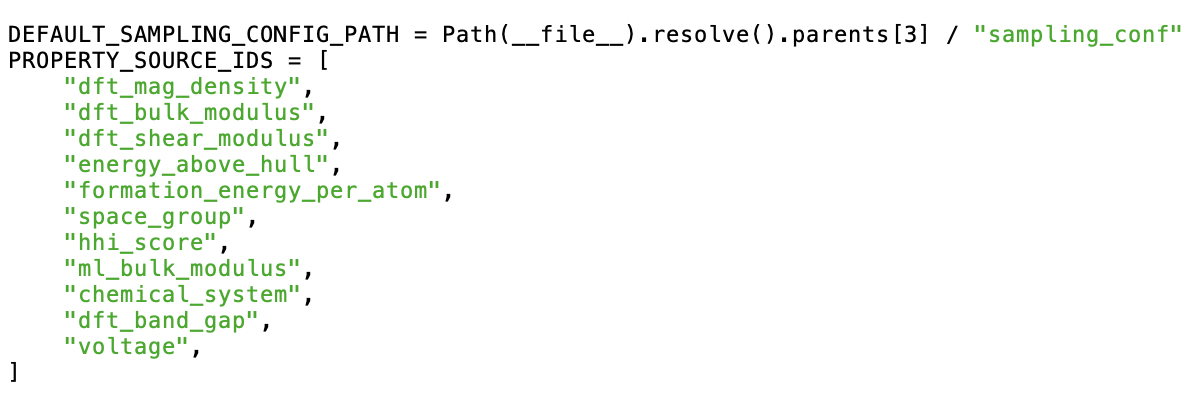

In [ ]:
# VERY IMPORTANT (Step 2 of 2)! To add a new property that Mattergen hasn't been trained on,
# need to add a new config file (voltage.yaml) at
# mattergen.conf.lightning_module.diffusion_module.model.property_embeddings

os.chdir('/content/mattergen')
!cp mattergen/conf/lightning_module/diffusion_module/model/property_embeddings/dft_bulk_modulus.yaml \
    mattergen/conf/lightning_module/diffusion_module/model/property_embeddings/voltage.yaml

# Then open the voltage.yaml file and change the property name. It should look like this:

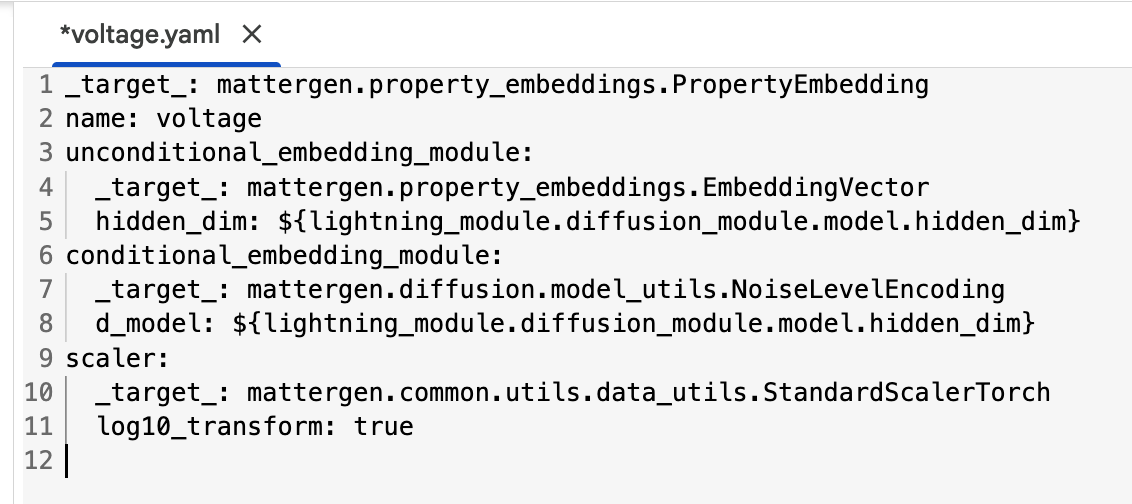

Here, there is a lengthy data preparation step. By default, we just copy the result of this code in from Google Drive. Running the script to create the data ready for Mattergen takes about 11 minutes

In [ ]:
# Preparing the data takes about 11 minutes. Alternatively, copy the cache.tar.gz
# file from the repo and place it in mattergen/datasets directory

os.chdir('/content/mattergen')

# If doing from scratch
#!python csv_to_dataset.py --csv-folder datasets/mp_20/ --dataset-name mp_20 --cache-folder datasets/cache

# Copy data from repo- saves ~11 minutes
!cp /content/mattergen_finetune/cache.tar.gz datasets/
!tar -zxf datasets/cache.tar.gz


In [ ]:
# Download the saved model weights for our finetuning

!git lfs pull -I checkpoints/mattergen_base --exclude=""


Ideally, Mattergen would be trained using multiple GPUs. On the free version of Colab, we have access to only 1 GPU of modest power. So, we need to significantly reduce the data batch sizes as described below to not run into an out of memory issue.

In [ ]:
# Important: since we only have 1 GPU available in the free version of Colab,
# Need to modify the data batch size to avoid out of memory errors

# Go to mattergen/conf/data_module/mp_20.yaml and change the batch sizes to be
# 32, 8 and 8 for train, val and test data, respectively. The file should look
# like below:

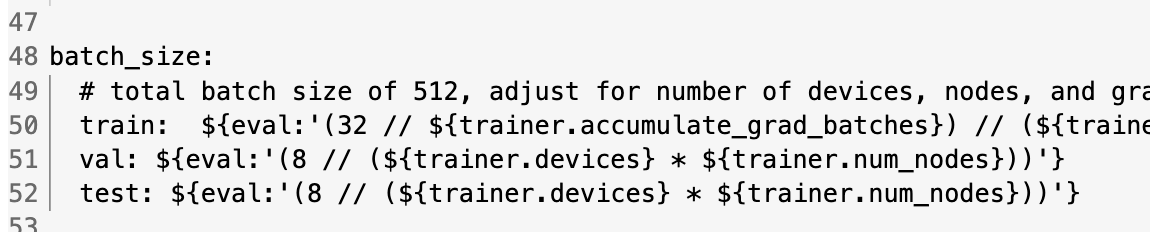

# Part 4: (Choice 2: Recommended for easy running): Copy the already modified mattergen code from the repo

In [18]:
# Copy the modified mattergen code from the Google Drive

!cp '/content/mattergen_finetune/mattergen.tar.gz' '/content'

In [19]:
# Remove the previously cloned repo

!rm -r mattergen

In [20]:
# Unpack the modified repo

!tar -xzvf mattergen.tar.gz

mattergen/
mattergen/SECURITY.md
mattergen/assets/
mattergen/assets/datasets_venn_diagram.png
mattergen/assets/MatterGenlogo_.png
mattergen/.git/
mattergen/.git/HEAD
mattergen/.git/objects/
mattergen/.git/objects/pack/
mattergen/.git/objects/pack/pack-8fc4b3f1eb56e7ec8877a9c046a2e7183bb827e6.idx
mattergen/.git/objects/pack/pack-8fc4b3f1eb56e7ec8877a9c046a2e7183bb827e6.pack
mattergen/.git/objects/info/
mattergen/.git/logs/
mattergen/.git/logs/HEAD
mattergen/.git/logs/refs/
mattergen/.git/logs/refs/remotes/
mattergen/.git/logs/refs/remotes/origin/
mattergen/.git/logs/refs/remotes/origin/HEAD
mattergen/.git/logs/refs/heads/
mattergen/.git/logs/refs/heads/main
mattergen/.git/description
mattergen/.git/config
mattergen/.git/info/
mattergen/.git/info/exclude
mattergen/.git/lfs/
mattergen/.git/lfs/incomplete/
mattergen/.git/lfs/tmp/
mattergen/.git/lfs/tmp/2126704037
mattergen/.git/lfs/tmp/428755528
mattergen/.git/lfs/tmp/1653481516
mattergen/.git/lfs/tmp/735251299
mattergen/.git/lfs/tmp/13402

# Part 5: Finetuning Mattergen on Na voltages

We are now ready to do the actual finetuning! Here, we only finetune for 25 epochs, so you can get a feel for the process. The resulting model will not be very good but can still be used to generate new structures. Below, we also show an example of copying another finetuned model which should provide improved results

In [21]:
os.chdir('/content/mattergen')

!mattergen-finetune adapter.pretrained_name=mattergen_base data_module=mp_20 \
  +lightning_module/diffusion_module/model/property_embeddings@adapter.adapter.property_embeddings_adapt.voltage=voltage \
  +lightning_module/diffusion_module/model/property_embeddings@adapter.adapter.property_embeddings_adapt.chemical_system=chemical_system \
  ~trainer.logger data_module.properties=["voltage","chemical_system"] trainer.accelerator=gpu trainer.devices=1 \
  trainer.max_epochs=10

MODELS_PROJECT_ROOT: /content/mattergen/mattergen
/usr/local/lib/python3.12/dist-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'finetune': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.12/dist-packages/hydra/_internal/hydra.py:119: UserWarning: Future Hydra versions will no longer change working directory at job runtime by default.
See https://hydra.cc/docs/1.2/upgrades/1.1_to_1.2/changes_to_job_working_dir/ for more information.
  ret = run_job(
Error executing job with overrides: ['adapter.pretrained_name=mattergen_base', 'data_module=mp_20', '+lightning_module/diffusion_module/model/property_embeddings@adapter.adapter.property_embeddings_adapt.voltage=voltage', '+lightning_module/diffusion_module/model/property_embeddings@adapter.adapter.property_embeddings_adapt.chemical_system=chemical_system', '~trainer.logger', 'data_modu

Below are instructions to either (1) use the model you just finetuned or (2) use the previously finetuned model from Google Drive. Some files need to be moved around before we can do the generation

In [ ]:
os.getcwd()

'/content/mattergen'

In [ ]:
# When training is complete, we can use the fine-tuned model to generate new structures.
# Note, the model is not going to be very good since we didn't train for very long.
# Alternatively, you can copy a trained model from the repo (shown below)

if not os.getcwd() == '/content/mattergen':
    os.chdir('/content/mattergen')

# First, need to copy the saved checkpoint in the outputs/singlerun/{TODAY'S DATE}/checkpoints folder
# to mattergen/checkpoints/{YOUR MODEL NAME}

# For example (note you will need to update the date when you run it)
#!cp -r outputs/singlerun/2025-09-04/16-15-50/lightning_logs/version_0/ mattergen/checkpoints/
#!mv mattergen/checkpoints/version_0 mattergen/checkpoints/my_new_model

#Use --model-path = 'mattergen/checkpoints/my_new_model'

# Alternatively, copy another model from repo which will be better
!cp -r /content/mattergen_finetune/chemical_system_energy_above_hull_voltage.zip mattergen/checkpoints/
!unzip mattergen/checkpoints/chemical_system_energy_above_hull_voltage.zip
!mv checkpoints/ chemical_system_energy_above_hull_voltage
!mv config.yaml chemical_system_energy_above_hull_voltage
!mv chemical_system_energy_above_hull_voltage mattergen/checkpoints
!mkdir mattergen/checkpoints/chemical_system_energy_above_hull_voltage/checkpoints
!mv mattergen/checkpoints/chemical_system_energy_above_hull_voltage/last.ckpt mattergen/checkpoints/chemical_system_energy_above_hull_voltage/checkpoints
!mv mattergen/checkpoints/chemical_system_energy_above_hull_voltage/epoch=134-loss_val=0.21.ckpt mattergen/checkpoints/chemical_system_energy_above_hull_voltage/checkpoints

#Use --model-path = 'mattergen/checkpoints/chemical_system_energy_above_hull_voltage'


Archive:  mattergen/checkpoints/chemical_system_energy_above_hull_voltage.zip
Written using ZipTricks 5.6.0
   creating: OLD/
   creating: OLD/checkpoints/
  inflating: OLD/checkpoints/last.ckpt  
  inflating: OLD/config.yaml         
   creating: checkpoints/
  inflating: checkpoints/epoch=134-loss_val=0.21.ckpt  
  inflating: checkpoints/last.ckpt   
  inflating: config.yaml             


# Part 6: Generating new materials with a finetuned Mattergen model

Now we can finally generate new structures! This process does take some time even on a GPU- about 1 minute per structure. Using the settings here will create 16 new structures and take roughly 15 minutes. You can reduce batch_size to make more or fewer structures.

In [ ]:
# Note that the present setting takes ~7 minutes for generation. Replace "my_new_model"
# with "chemical_system_energy_above_hull_voltage" if using the pre-trained
# model from the repo

!mattergen-generate results --model-path=mattergen/checkpoints/chemical_system_energy_above_hull_voltage --batch_size=8 \
  --properties_to_condition_on="{'voltage': 4.0, 'chemical_system': 'Na-Mn-C-P-O'}" \
  --diffusion_guidance_factor=2.0 --num_batches=1

MODELS_PROJECT_ROOT: /content/mattergen/mattergen

Model config:
/content/mattergen/mattergen/common/utils/data_classes.py:96: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with initialize_config_dir(str(self.model_path)):
adapter:
  adapter:
    _target_: mattergen.adapter.GemNetTAdapter
    atom_type_diffusion: mask
    denoise_atom_types: true
    gemnet:
      _target_: mattergen.common.gemnet.gemnet_ctrl.GemNetTCtrl
      atom_embedding:
        _target_: mattergen.common.gemnet.layers.embedding_block.AtomEmbedding
        emb_size: 512
        with_mask_type: true
      condition_on_adapt:
      - voltage
      - energy_above_hull
      - chemical_system
      cutoff: 7.0
      emb_size_atom: 512
      emb_size_edge: 512
      latent_dim: 512
      max_cell_images_per_dim: 5
      max_neighbors: 50
      num_blocks: 4
      num_targets: 1
      otf_graph: true
      regress_

In [ ]:
# Now that we have some generated structures, we can open them and examine the
# resulting compositions and structures

!unzip results/generated_crystals_cif.zip

Archive:  results/generated_crystals_cif.zip
 extracting: gen_0.cif               
 extracting: gen_1.cif               
 extracting: gen_2.cif               
 extracting: gen_3.cif               
 extracting: gen_4.cif               
 extracting: gen_5.cif               
 extracting: gen_6.cif               
 extracting: gen_7.cif               


Alternatively, we can copy a folder of generated structures from a previous run

In [22]:
!cp /content/mattergen_finetune/generated_crystals_cif.zip .
!unzip generated_crystals_cif.zip

Archive:  generated_crystals_cif.zip
 extracting: gen_0.cif               
 extracting: gen_1.cif               
 extracting: gen_2.cif               
 extracting: gen_3.cif               
 extracting: gen_4.cif               
 extracting: gen_5.cif               
 extracting: gen_6.cif               
 extracting: gen_7.cif               
 extracting: gen_8.cif               
 extracting: gen_9.cif               
 extracting: gen_10.cif              
 extracting: gen_11.cif              
 extracting: gen_12.cif              
 extracting: gen_13.cif              
 extracting: gen_14.cif              
 extracting: gen_15.cif              
 extracting: gen_16.cif              
 extracting: gen_17.cif              
 extracting: gen_18.cif              
 extracting: gen_19.cif              
 extracting: gen_20.cif              
 extracting: gen_21.cif              
 extracting: gen_22.cif              
 extracting: gen_23.cif              
 extracting: gen_24.cif              
 extracting: 

# Part 7: Visualize your generated structures and calculate their average voltage with a U-MLIP

In [23]:
# Visualize (change supercell/style as needed)

from pymatgen.core import Structure
struct = Structure.from_file("gen_71.cif")
print(struct.reduced_formula)
show_structure_3d(struct, supercell=(2, 2, 2), style="ballstick", spin=False, labels=True)

NaMn(CO3)2


/usr/local/lib/python3.12/dist-packages/pymatgen/core/structure.py:2945: UserWarning: Site labels are not unique, which is not compliant with the CIF spec (https://www.iucr.org/__data/iucr/cifdic_html/1/cif_core.dic/Iatom_site_label.html):`['Na1', 'Na1', 'Na1', 'Na1', 'Na1', 'Na1', 'Na1', 'Na1', 'Mn1', 'Mn1', 'Mn1', 'Mn1', 'Mn1', 'Mn1', 'Mn1', 'Mn1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'O1', 'O1', 'O1', 'O1', 'O1', 'O1', 'O1', 'O1', 'O2', 'O2', 'O2', 'O2', 'O2', 'O2', 'O2', 'O2', 'O3', 'O3', 'O3', 'O3', 'O3', 'O3', 'O3', 'O3', 'O4', 'O4', 'O4', 'O4', 'O4', 'O4', 'O4', 'O4', 'O5', 'O5', 'O5', 'O5', 'O5', 'O5', 'O5', 'O5', 'O6', 'O6', 'O6', 'O6', 'O6', 'O6', 'O6', 'O6']`.
  writer: Any = CifWriter(self, **kwargs)


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Need to install a U-MLIP. Here, we will use CHGNet


In [24]:
!pip install chgnet

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 89.4 MB/s eta 0:00:00
  Created wheel for nvidia-ml-py3: filename=nvidia_ml_py3-7.352.0-py3-none-any.whl size=19172 sha256=8b83d7e9b6114825da09670a4c65a4e019084f70b47265a1de064d85e7978c98
  Stored in directory: /root/.cache/pip/wheels/6e/65/79/33dee66cba26e8204801916dfee7481bccfd22905ebb841fe5
Successfully built nvidia-ml-py3


We can use a Universal Machine Learning Potential (U-MLIP) to relax the generated structure and get a total energy. By calculating the energies with and without Na, we can get an average Na voltage

In [25]:
from chgnet.model import StructOptimizer
from pymatgen.core import Structure, Element
from copy import copy

def relax(s):
    # 1) Load your starting structure
    #s = Structure.from_file(cif_file)

    # 2) Create the CHGNet relaxer (uses GPU if available; CPU otherwise)
    relaxer = StructOptimizer()  # you can pass device="cuda" or "cpu"

    # 3) Relax (tune fmax for tighter/looser forces; steps is a hard cap)
    result = relaxer.relax(
        s,
        fmax=0.05,        # eV/Å target force (typical: 0.05–0.1)
        steps=1000,       # max optimizer steps
        relax_cell=True,  # True = relax lattice + ions; False = fixed cell
        verbose=True
    )

    relaxed = result["final_structure"]           # pymatgen.Structure
    E_final = result["trajectory"].energies[-1]   # eV

    return relaxed, E_final

def drop_element(struct: Structure, element: str | Element) -> Structure:
    #el = Element(element) if not isinstance(element, Element) else element
    idx_to_remove = []
    for i, site in enumerate(struct.sites):
        # site.species is a dict-like {Species: occupancy}; Species.element is an Element
        #if any(getattr(sp, "element", None) == el for sp in site.species.keys()):
        if site.specie == Element(element):
            idx_to_remove.append(i)
    print(idx_to_remove)
    new = struct.copy()
    if idx_to_remove:
        new.remove_sites(idx_to_remove)
    return new

def get_voltage(ion, final_structure_full, final_structure_empty, final_structure_ref, final_energy_full, final_energy_empty, final_energy_ref):
    #from copy import copy
    final_structure_full_copy = copy(final_structure_full)
    final_structure_empty_copy = copy(final_structure_empty)
    num_ref = final_structure_ref.composition.as_dict()[ion]
    #before = len(final_structure_full_copy)
    final_structure_full_copy.remove_species([ion]) # Needed to get ratio of fu's
    final_structure_empty_copy.remove_species([ion]) # Needed to get ratio of fu's
    #after = len(final_structure_full_copy)
    #num_fu_full = final_structure_full.composition.num_atoms / final_structure_full.composition.reduced_composition.num_atoms
    #num_fu_empty = final_structure_empty.composition.num_atoms / final_structure_empty.composition.reduced_composition.num_atoms
    fu_ratio = final_structure_full_copy.composition.num_atoms / final_structure_empty_copy.composition.num_atoms
    #num_int = final_structure_full.composition.reduced_composition.as_dict()['Na']/num_fu_full - final_structure_empty.composition.reduced_composition.as_dict()['Na']/num_fu_empty
    #num_int = before - after
    Na_full = final_structure_full.composition.as_dict()[ion]
    try:
        Na_empty = final_structure_empty.composition.as_dict()[ion]*fu_ratio
    except:
        Na_empty = 0
    num_int = Na_full - Na_empty
    #print('ref, int, furatio')
    #print(num_ref, num_int, fu_ratio)
    if ion in ['Mg', 'Ca']:
        multiplier = 2
    else:
        multiplier = 1
    voltage = -1*(final_energy_full - fu_ratio*final_energy_empty - (num_int*final_energy_ref)/num_ref) / (num_int*multiplier)
    return voltage


We select one of our generated structures, and do a full relaxation of the generated structure (assumed to be filled with Na, discharge state) and a version with all Na removed (the charged state), and calculate the average Na voltage

In [26]:
# Relax the full cell
s = Structure.from_file("gen_71.cif")
s_full, E_final = relax(s)
print("Final CHGNet energy (eV):", E_final)

# Relax the Na empty cell
s_empty = drop_element(s, element='Na')
s_empty, E_final_empty = relax(s_empty)
print("Final CHGNet energy of empty cell (eV):", E_final_empty)

# Open Na ref structure and relax
s_ref = Structure.from_file("/content/mattergen_finetune/Na.cif")
s_ref, E_final_ref = relax(s_ref)
print("Final CHGNet energy of ref cell (eV):", E_final_ref)

# Get the voltage
voltage = get_voltage('Na', s_full, s_empty, s_ref, E_final, E_final_empty, E_final_ref)
print("Na voltage:", voltage)

CHGNet v0.3.0 initialized with 412,525 parameters
CHGNet will run on cpu
      Step     Time          Energy          fmax
FIRE:    0 16:14:28      -78.167958        0.316465
FIRE:    1 16:14:29      -78.171883        0.252949
FIRE:    2 16:14:29      -78.175063        0.187407
FIRE:    3 16:14:30      -78.176947        0.253301
FIRE:    4 16:14:30      -78.179488        0.186724
FIRE:    5 16:14:31      -78.181267        0.116325
FIRE:    6 16:14:32      -78.182087        0.218033
FIRE:    7 16:14:33      -78.182578        0.191853
FIRE:    8 16:14:33      -78.183346        0.145167
FIRE:    9 16:14:33      -78.184114        0.094101
FIRE:   10 16:14:34      -78.184705        0.089479
FIRE:   11 16:14:34      -78.185124        0.110809
FIRE:   12 16:14:35      -78.185568        0.141438
FIRE:   13 16:14:35      -78.186154        0.137864
FIRE:   14 16:14:36      -78.186874        0.107524
FIRE:   15 16:14:36      -78.187585        0.082968
FIRE:   16 16:14:36      -78.188262        0.

/usr/local/lib/python3.12/dist-packages/pymatgen/core/structure.py:3109: UserWarning: Issues encountered while parsing CIF: 4 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  struct = parser.parse_structures(primitive=primitive)[0]


FIRE:    1 16:15:46       -2.588425        0.075117
FIRE:    2 16:15:46       -2.588553        0.072621
FIRE:    3 16:15:46       -2.588733        0.068927
FIRE:    4 16:15:46       -2.588959        0.064100
FIRE:    5 16:15:46       -2.589217        0.058239
FIRE:    6 16:15:46       -2.589494        0.051498
FIRE:    7 16:15:46       -2.589777        0.044075
Final CHGNet energy of ref cell (eV): -2.5897769927978516
Na voltage: 4.276301383972168


By using the gen_71.cif structure from the stuctures generated previously and available on the repo, (discharge composition NaMn(CO3)2), we get a Na voltage of 4.28 V/Na, which is interesting!

We note there will be generated structures that don't have relevant elements or whose properties don't match the target you're going for, but it is fairly fast to generate and evaluate new potential structures.